# Refrigeration Cycle Simulations

This notebook demonstrates the modeling framework developed in Ganz (2023) using two examples of refrigeration cycles:
1. one-stage refrigeration cycle that utilizes R134a as refrigerant;
2. cascade cycle that uses CO₂/R134a as refrigerant.

## Modeling Framework for Representing Thermal Hydraulic Circuits

Thermal hydraulic circuits, including pipes, pumps, compressors, heat exchangers, valves, and more, can be effectively represented in an object oriented programming language like Python. The components, system variables

## One Stage DX Cycle Simulation

The first simulation focuses on a one-stage R134a refrigeration cycle comprising a compressor, condenser, expansion valve, and evaporator (Figure 1). The compressor, of semi-hermetic reciprocating type, operates at a speed of 1450 rpm and delivers a volume flow rate of 41.33 m³/h. It consumes 4.68 kW under nominal conditions. The compressor is modeled as a pressure-based component using a compressor polynomial function:

$$ y = c_1 + c_2T_v + c_3T_c + c_4T_v^2 + c_5T_vT_c + c_6T_c^2 + c_7T_v^3 + c_8T_vT_c^2 + c_9T_vT_c^2 + c_{10}T_vT_c^3$$

where:

- $y$ represents the mass flow rate, kg/h;
- $T_v$ - evaporating temperature, °C;
- $T_c$ - condensing temperature, °C.
- $c_1, c_2...c_{10}$ - coefficients obtained from the compressor manufacturer (Ganz, 2023).

The evaporation and condensation processes occur within plate heat exchangers with heat transfer areas of 2.64 m² and 3.65 m², respectively. The evaporator uses air as the cooling medium, while the condenser employs water as the heat transfer medium.

For the evaporator and condenser, a mass flow-based component approach known as the Moving-Boundary Model is employed (Bitzer Software, 2013). This model considers heat transfer and pressure loss coefficients for each phase within the condenser, determined by correlations from (Bell at al. 2015), and for the evaporator, determined by correlations from (Longo, 2008).

The expansion valves are pressure-based components implemented using a Fixed Orifice Model. The mass flow rates at the input and output ports are:

$$\dot{m}_{i,ev} = \dot{m}_{o,ev} = C_f\sqrt{\rho(p_{i,ev} − p_{o,ev})}$$

where:
- $C_f$ represents a constant flow coefficient characterizing the valve;
- $\rho$ - density of the refrigerant, **liquid / vapor** phase, kg·m⁻³;
- $p_{i,ev}, p_{o,ev}$ - input and ouput pressure of the refrigerant (**why** $_{ev}$), Pa. 

It is supposed that the process in the expansion valve is isenthalpic:

$$h_{i,ev} = h_{o,ev}$$

The components are modeled as either pressure-based or mass flow-based components. For a pressure-based component, the input variables are inlet and outlet pressure values $p_i$ and $p_o$ and inlet enthalpy $h_i$ and the output variables are inlet and outles mass flow rates $\dot{m}_i$ and $\dot{m}_o$ as well as specific enthalpy $h_i$ at the inlet of the component. For a mass flow-based component, the inputs are pressure values $p_i$, specific enthalpies $h_i$ and mass flow rates $m_i$ at the inlet of the component and the output variables are the pressure $p_o$ values, specific enthalpies $h_o$ and mass flow rates $m_o$ at all outlets of the component.

**You need to define the input variables of the model, the tearing variables and the state - or internal or system - variables. This would be a transition to the next section on junction-port connectivity matrix**

Figure 1 shows the principle of the a one stage DX cycle including the tearing variables, boundary conditions, and system variables.

![fig](./Cycles/OneStageDX/Circuit_OneStageDX.svg)
>Figure 1. One-Stage DX cycle scheme.

### Junction Port Connectivity Matrix (JPCM ) representing One Stage DX Cycle
Each component of a cycle has input and output _ports_ representing its physical inlets and outlets. These ports contain all 
the information needed to solve the system of equations [**I don't agree. You need also the models and the parameters of each component**]. Numerical _junctions_ describe how the input and output ports of the components are connected to each other. At a junction, the pressure of all connecting ports must be equal and the mass and energy conservation equations must be satisfied. The 
_Junction-Port-Connectivity-Matrix_ (JPCM) specifies which ports are connected to which junctions. The rows of the JPCM correspond to the junctions, and the columns to the components.

The JPCM representing the One Stage DX cycle is presented in Table 1.

(**Table 1 does not seem to be a matrix it looks as a [Tidy Data table](https://vita.had.co.nz/papers/tidy-data.pdf). Expalain why there are 8 junctions in Table 1 and 4 junctions in Figure 1. Explain wht is the meaning of the values from Table 1; p, -p, h, -h, c, -c, 1, -1, and 0. Explain what is fluid loop and what the values 1, 2, 3 represent.**)

Looking at the compressor column of the JPCM, we can see that this component is connected to junction 1 by a regular input port and to junction 2 by a regular output port, meaning that the compressor receives information of junction 1 with which the compressor model is being solved and gives its output informati onto junction 2. Likewise, the expansion valve receives information from junction 3 and gives information to junction 4. The condenser and evaporator each have ports for their hot- and cold-side. The hot side of the condenser receives information from junction 2 and gives information to junction 3. Its cold side is connected to junctions 5 and 6, we can see that these junctions are part of fluid loop 2, that junction 5 is a source (1) and junction 6 a sink (-1). In the scheme we only see _Source_- and _Sink_-tags that "hide" the numbers of the junctions. Equally for the evaporator, the only difference naturally being that the hot side is connected to the second open fluid loop and the cold side to the closed fluid loop. 

The equations necessary to solve the system are being created at the junctions based on the JPCM.

> Table 1. Junction-Port Connectivity Matrix (JPCM)

|Junction | Compressor | Condenser | Expansion Valve | Evaporator | Fluid Loop | Source / Sink |
|---------|-----------:|----------:|----------------:|-----------:|-----------:|--------------:|
|  1      | p          | 0         | 0               | -c         | 1          | 0             |
|  2      | -p         | h         | 0               | 0          | 1          | 0             |
|  3      | 0          | -h        | p               | 0          | 1          | 0             |
|  4      | 0          | 0         | -p              | c          | 1          | 0             |
|  5      | 0          | c         | 0               | 0          | 2          | 1             |
|  6      | 0          | -c        | 0               | 0          | 2          | -1            |
|  7      | 0          | 0         | 0               | h          | 3          | 1             |
|  8      | 0          | 0         | 0               | -h         | 3          | -1            |

The entries of the matrix are the ports connecting component and junction (**What is an *entry* of the matrix?**). The ports can be one of two types. If the port 
in a cell is positive, it is an input port (with respect to the component), if it is negative, it is an output port. 
Also, there are different specifications of ports: regular ports, heat exchanger hot side ports, heat exchager cold side ports.
All current possibilities are summarized in Table 2.

> Table 2. Types of ports in Junction-Port Connectivity Matrix (JPCM).

| Port                                 | Letter code |
|:-------------------------------------|------------:|
| Regular input port                   |      p      |
| Regular output port                  |     -p      |
| Heat Exchanger hot side input port   |      h      |
| Heat Exchanger hot side output port  |     -h      |
| Heat Exchanger cold side input port  |      c      |
| Heat Exchanger cold side output port |     -c      |

### Generating One Stage DX system components and equations corresponding to JPCM

(**The description of the code needs revision. If the solving algorithm is described, it needs to be understandable (i.e., explain that a system of equations is constructed for each junction, the use of tripartite graph and tearing algorithm; explain what is the 'design euation'. But you can keep on the level of abstraction of the user and not describe the algorithm**)

The JPCM for a one-stage R134a refrigeration cycle is laoded from a CSV file. It also defines lists for the solver path and boundary types of the components. The component types, solver paths, boundary types, and fluids for each component are specified. Components are created based on the defined parameters, and the corresponding fluids are assigned to each port. The Tripartite Graph of the system is generated using the JPCM. Finally, a tearing algorithm is executed to identify tearing variables `Vt`, create an execution list `exec_list`, determine the residual equation `res_equa`, and calculate the necessity and number of design equations `design_equa`, based on the Tripartite Graph.

In that case the tearing algorithm identifies the tearing variables $p_{i,co}$, $h_{i,co}$ and $p_{o,co}$ and $p_{o,ev}$ and residual equations:

1. $h_{i_co} - h_{o, v} = 0$

2. $p_{i_co} - p_{o,v} = 0$

3. $\dot{m}_{i,ev} -\dot{m}_{o,c} = 0$.

These equations represent the energy balance and pressure equality at junction 1 and the mass balance at junction 3. However, to fully close the system of equations, one more design equation is required. This additional design equation is necessary to provide sufficient constraints and determine the remaining unknowns in the system.

### System Simulation Class, Function and Module Imports

(**This is on another level of abstraction. It is not necessary to explain.**)

The code imports various modules and functions needed for the system simulation. These include `Component`, `PressureBasedComponent`, `MassFlowBasedComponent`, `BypassComponent`, `BalanceEquation`, `EnthalpyFlowBalance`, `SuperheatEquation`, `SubcoolingEquation`, `TripartiteGraph`, `tearing_alg`, `system_solver`, `logph`, `psd`, `set_bc_values_onestage`, `set_dc_values_onestage`, `set_bc_values_cascade`, `set_dc_values_cascade`.

Additional imports include `os`, `csv`, `codecs` for file handling, `PropsSI` from the CoolProp library for thermodynamic property calculations, `ipywidgets` for creating interactive widgets, and `display` from IPython.display for visualizing the widgets.

In [1]:
from system import *
import os
import csv
import codecs
from CoolProp.CoolProp import PropsSI
import ipywidgets as wd
from IPython.display import display
import pandas as pd

### Generating One Stage DX system components and equations corresponding to JPCM
The code snippet loads the JPCM for a one-stage R134a refrigeration cycle from a CSV file and initializes it as a list. It also defines lists for the solver path and boundary types of the components. The component types, solver paths, boundary types, and fluids for each component are specified. Components are created based on the defined parameters, and the corresponding fluids are assigned to each port. The Tripartite Graph of the system is generated using the JPCM. Finally, a tearing algorithm is executed to identify tearing variables `Vt`, create an execution list `exec_list`, determine the residual equation `res_equa`, and calculate the necessity and number of design equations `design_equa`, based on the Tripartite Graph.

In that case the tearing algorithm identifies the tearing variables $p_{i,co}$, $h_{i,co}$ and $p_{o,co}$ and $p_{o,ev}$ and residual equations:

1. $h_{i_co} - h_{o, v} = 0$

2. $p_{i_co} - p_{o,v} = 0$

3. $\dot{m}_{i,ev} -\dot{m}_{o,c} = 0$.

These equations represent the energy balance and pressure equality at junction 1 and the mass balance at junction 3. However, to fully close the system of equations, one more design equation is required. This additional design equation is necessary to provide sufficient constraints and determine the remaining unknowns in the system.

In [8]:
# generates JPCM from .csv-file
directory = os.getcwd()
data = pd.read_csv(directory + '/Cycles/OneStageDX/JPCM.csv', sep=';', encoding='utf-8-sig', header=None)
component_typ_list = data.loc[0,1:len(data.loc[0,1:])-2].to_numpy()
jpcm = data.loc[1:,1:].to_numpy().astype(int)

# defines component types of the cycle
component_type_list = ['Compressor', 'Condenser', 'Expansion Valve', 'Evaporator']

component_name_list = component_typ_list.copy()

# defines the solver path of each component
solver_path_list = [directory + '/Cycles/OneStageDX/Components/Compressor/Polynomial based Model',
                    directory + '/Cycles/OneStageDX/Components/Condenser/Moving Boundary Model',
                    directory + '/Cycles/OneStageDX/Components/ExpansionValve',
                    directory + '/Cycles/OneStageDX/Components/Evaporator/Moving Boundary Model']

# defines modeling type of each component
component_modeling_type_list = ['PressureBasedComponent', 
                                'MassFlowBasedComponent', 
                                'PressureBasedComponent', 
                                'MassFlowBasedComponent']

# defines fluids of each fluid loop
fluid_list = ['R134a', 'Air', 'Water']
fluid_list = ['R134a', 'INCOMP::TY20', 'Water']

# generates components and sets corresponding fluid to each port
components = []
for i, item in enumerate(component_typ_list):
    if component_modeling_type_list[i] == 'PressureBasedComponent':
        components.append(PressureBasedComponent(i+1, item, component_name_list[i], jpcm))
    elif component_modeling_type_list[i] == 'MassFlowBasedComponent':
        components.append(MassFlowBasedComponent(i+1, item, component_name_list[i], jpcm))
    elif component_modeling_type_list[i] == 'BypassComponent':
        components.append(BypassComponent(i + 1, item, component_name_list[i], jpcm))
    for port in components[i].ports:
        port.fluid = fluid_list[port.port_id[-2]-1]
    components[i].solver_path = solver_path_list[i]
    
# defines parameter of the components
components[0].parameter = {'f': 50}  # compressor frequency [Hz]
components[1].parameter = {'A': 3.65}  # heat exchanger area [m2]
components[2].parameter = {'CA': 5.0e-6}  # valve flow coeffcient
components[3].parameter = {'A': 2.65}  # heat exchanger area [m2]

# generates the systems Tripartite Graph from JPCM
tpg = TripartiteGraph(jpcm, components)

# runs tearing algorithm to identify tearing variable, execution list, residual equation and the necessity and number of
# design equations
Vt, exec_list, res_equa, design_equa = tearing_alg(tpg)

### Setting One Stage DX system boundary conditions and design criterias
The code snippet defines the boundary conditions and design criteria for the refrigeration cycle. The boundary conditions include the inlet temperature ($T_{i,c,so}$ and $T_{i,v,so}$), inlet pressure ($p_{i,c,so}$ and $p_{i,v,so}$), and mass flow rate ($\dot{m}_{i,c,so}$ and $\dot{m}_{i,v,so}$) for the condenser and evaporator on their secondary side. The design criteria specify the desired superheat `DC_SH` in the evaporator (**What is this?**).

The boundary conditions are then set for the corresponding components in the system. (**Boundary conditions of inputs of the component?**) For the evaporator, the inlet pressure, enthalpy, and mass flow rate are assigned. Similarly, for the condenser, the inlet pressure, enthalpy, and mass flow rate are set.

The code also defines scale factors for the solver and initial values for the variables that will be solved. The initial values include the compressor inlet pressure, enthalpy, and the outlet pressures for the condenser and evaporator.

These values will be used as starting points for the solver to find the solution to the refrigeration cycle.

In [12]:
# interactive-widget for additional accessing of input values
wid_inputs_onestage = wd.interactive(set_inputs_onestage, pi_v_so=(0.5,3.0,0.1), Ti_v_so=(-20,0,0.1), mi_v_so=(5.0,10.0,0.1),
                    pi_c_so=(0.5,3.0,0.1), Ti_c_so=(20,40,0.1), mi_c_so=(5.0,10.0,0.1))

print('Boundary condition values:')
display(wid_inputs_onestage)

# interactive-widget for additional accessing of design criteria
wid_DC_onestage = wd.interactive(set_dc_values_onestage, SH_v=(0.0,20.0,0.1))
print('Design criteria values:')
display(wid_DC_onestage)

Boundary condition values:


interactive(children=(FloatSlider(value=1.0, description='pi_v_so', max=3.0, min=0.5), FloatSlider(value=-5.0,…

Design criteria values:


interactive(children=(FloatSlider(value=5.0, description='SH_v', max=20.0), Output()), _dom_classes=('widget-i…

### Solving One Stage DX system and plotting results

The provided code snippet accomplishes the following tasks:

1. Resetting component ports by calling the `reset()` method on each component and setting the `linearized` attribute to `False`.

2. Running the system solver to solve the system of equations of the cycle by invoking the `system_solver()` function with appropriate parameters and storing the result in the `sol` variable.

3. Extracting the solution vector from `sol['x']` and assigning it to the `x` variable.

4. Solving and executing system equations and components by updating the component ports with the junction values corresponding to the solution. This involves iterating over the tearing variables and setting the values of pressure, enthalpy, and mass flow rate based on the tearing variable type and scale factors. Then, the system equations and components are solved and executed.

5. Extracting and storing junction values, including pressure, enthalpy, and temperature, from specific component ports.

6. Plotting a log-ph diagram using the `logph()` function with enthalpy and pressure values for a specific fluid.

7. Printing the junction values in a tabular format, including the junction number, pressure, enthalpy, and temperature.

8. Resetting all component ports by calling the `reset()` method on each component.

In summary, the code performs system solving, updates component ports, extracts and displays junction values, plots a log-ph diagram, and resets component ports.

Start Broyden Solver
computing Jacobian...
Iteration 1 / Max-Norm of Residuals: 0.6934842281270294
Iteration 2 / Max-Norm of Residuals: 0.6730270315903443
Iteration 3 / Max-Norm of Residuals: 0.5673878121653763
Iteration 4 / Max-Norm of Residuals: 0.45344119328784727
Iteration 5 / Max-Norm of Residuals: 0.9090785040962939
Iteration 6 / Max-Norm of Residuals: 0.7120419571908994
Iteration 7 / Max-Norm of Residuals: 0.6609740669015735
Iteration 8 / Max-Norm of Residuals: 0.7016828983841714
Iteration 9 / Max-Norm of Residuals: 0.5619647048195342
Iteration 10 / Max-Norm of Residuals: 0.48981432849860973
Iteration 11 / Max-Norm of Residuals: 0.8730507228998503
Iteration 12 / Max-Norm of Residuals: 0.556812705138182
Iteration 13 / Max-Norm of Residuals: 0.6586751717622534
Iteration 14 / Max-Norm of Residuals: 0.5216021998005428
Iteration 15 / Max-Norm of Residuals: 0.43139093877494317
Iteration 16 / Max-Norm of Residuals: 0.7566212652315809
Iteration 17 / Max-Norm of Residuals: 0.673226129357

C:\Users\ganm\AppData\Local\Programs\Python\Python310\lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(
C:\Users\ganm\AppData\Local\Programs\Python\Python310\lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_child1), but could not find a label for it.
  warnings.warn(


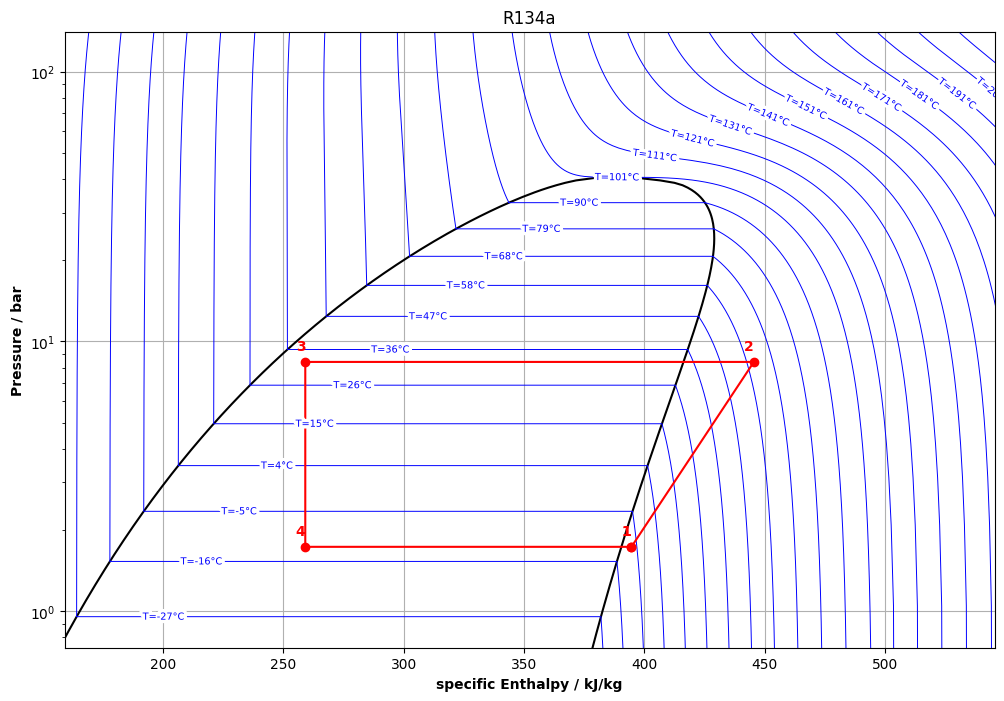

Junction 1:  p = 1.732 bar, h = 394.638 kJ/k, T = -8.66 °C, m = 0.079 kg/s
Junction 2:  p = 8.393 bar, h = 445.499 kJ/K, T = 61.178 °C, m = 0.079 kg/s
Junction 3:  p = 8.393 bar, h = 259.136 kJ/K, T = 33.024 °C, m = 0.079 kg/s
Junction 4:  p = 1.732 bar, h = 259.136 kJ/K, T = -13.66 °C, m = 0.079 kg/s


In [13]:
# resets all compontent ports
[(component.reset(), setattr(component, 'linearized', False)) for component in components]

# gets input values from widget input
inputs_onestage = wid_inputs_onestage.kwargs

pi_v_so = inputs_onestage['pi_v_so']
Ti_v_so = inputs_onestage['Ti_v_so']
mi_v_so = inputs_onestage['mi_v_so']

pi_c_so = inputs_onestage['pi_c_so']
Ti_c_so = inputs_onestage['Ti_c_so']
mi_c_so = inputs_onestage['mi_c_so']

# gets design criteria value from widget input
dc_values_onestage = wid_DC_onestage.kwargs
SH_v = dc_values_onestage['SH_v']

# sets boundary condition values to corresponding components
for i, c in enumerate(components):
    if c.component_type == 'Evaporator':
        for port in c.ports:
            if port.port_id[-1] == 1:
                port.p.set_value(pi_v_so * 1e5)
                port.h.set_value(PropsSI('H', 'P', pi_v_so * 1e5, 'T', Ti_v_so + 273.15, port.fluid))
                port.m.set_value(mi_v_so)
    elif c.component_type == 'Condenser':
        for port in c.ports:
            if port.port_id[-1] == 1:
                port.p.set_value(pi_c_so * 1e5)
                port.h.set_value(PropsSI('H', 'P', pi_c_so * 1e5, 'T', Ti_c_so + 273.15, port.fluid))
                port.m.set_value(mi_c_so)
                
# generates superheat design equation and sets evaporator superheat value                 
design_equa = [SuperheatEquation(components[3], SH_v, 'out', 'h', psd['-c'])]
                
# solver scale factors
scale_factors = [1e-5, 1e-5, 10]

# solver initial values
pi_co0 = PropsSI('P', 'T', Ti_v_so + 273.15 - 5, 'Q', 1.0, fluid_list[Vt[1].port_id[-2]-1])
hi_co0 = PropsSI('H', 'P', pi_co0, 'Q', 1.0, fluid_list[Vt[1].port_id[-2]-1])
po_co0 = PropsSI('P', 'T', Ti_c_so + 273.15 + 5, 'Q', 1.0, fluid_list[Vt[1].port_id[-2]-1])
po_ev0 = pi_co0
x0 = [pi_co0, hi_co0, po_co0, po_ev0]

# runs the system solver to solve the system of equations of th cycle
sol = system_solver(x0, Vt, components, exec_list, res_equa, design_equa, scale_factors)

# solution vector of tearing variables
x = sol['x']


## you may use `match` Statements


if not sol['converged']:
    print(sol['message'])

else:
    # solves and exectutes all system equations and components to set all component ports by its junction value corresponding
    # to the solution
    for j, variable in enumerate(Vt):
        if variable.var_type == 'p':
            variable.set_value(x[j] / scale_factors[0])
        elif variable.var_type == 'h':
            variable.set_value(x[j] / scale_factors[1])
        elif variable.var_type == 'm':
            variable.set_value(x[j] / scale_factors[2])
    for item in exec_list:
        if isinstance(item, BalanceEquation) or isinstance(item, EnthalpyFlowBalance):
            item.solve()
        elif isinstance(item, Component):
            item.solve()

    # junction values corresponding to the solution
    pi_co, hi_co, mi_co  = components[0].ports[0].p.value, components[0].ports[0].h.value, components[0].ports[0].m.value
    pi_c,  hi_c, mi_c   = components[1].ports[0].p.value, components[1].ports[0].h.value, components[1].ports[0].m.value
    pi_ev, hi_ev, mi_ev  = components[2].ports[0].p.value, components[2].ports[0].h.value, components[2].ports[0].m.value
    pi_v,  hi_v, mi_v   = components[3].ports[1].p.value, components[3].ports[1].h.value, components[3].ports[1].m.value
    Ti_co = PropsSI('T', 'P', pi_co, 'H', hi_co, fluid_list[0]) - 273.15
    Ti_c  = PropsSI('T', 'P', pi_c, 'H', hi_c, fluid_list[0]) - 273.15
    Ti_ev = PropsSI('T', 'P', pi_ev, 'H', hi_ev, fluid_list[0]) - 273.15
    Ti_v  = PropsSI('T', 'P', pi_v, 'H', hi_v, fluid_list[0]) - 273.15

    # plots log ph diagramm
    logph([[hi_co * 1e-3, hi_c * 1e-3, hi_ev * 1e-3, hi_v * 1e-3, hi_co * 1e-3]],
          [[pi_co * 1e-5, pi_c * 1e-5, pi_ev * 1e-5, pi_v * 1e-5, pi_co * 1e-5]],
          [[1, 2, 3, 4, 1]],
          [fluid_list[0]])

    print(f'Junction 1:  p = {round(pi_co/1e5, 3)} bar, h = {round(hi_co/1e3, 3)} kJ/k, T = {round(Ti_co, 3)} °C, m = {round(mi_co, 3)} kg/s')
    print(f'Junction 2:  p = {round(pi_c/1e5, 3)} bar, h = {round(hi_c/1e3, 3)} kJ/K, T = {round(Ti_c, 3)} °C, m = {round(mi_c, 3)} kg/s')
    print(f'Junction 3:  p = {round(pi_ev/1e5, 3)} bar, h = {round(hi_ev/1e3, 3)} kJ/K, T = {round(Ti_ev, 3)} °C, m = {round(mi_ev, 3)} kg/s')
    print(f'Junction 4:  p = {round(pi_v/1e5, 3)} bar, h = {round(hi_v/1e3, 3)} kJ/K, T = {round(Ti_v, 3)} °C, m = {round(mi_v, 3)} kg/s')


## CO$_2$/R134a Cascade Simulation

In the second case, an indirect two-stage or cascade system is simulated. It consists of two single-stage cycles that are thermally coupled using two cascade heat exchangers. These heat exchangers operate in parallel, serving as the evaporator for the high-temperature (HT) cycle and the condenser for the low-temperature (LT) cycle. CO$_2$ is used as the refrigerant in the LT cycle, while R134a is used in the HT cycle. This configuration enables efficient heat transfer and temperature control between the two cycles.

To model the compressors, compressor polynomial maps were employed, and their coefficients were determined using software provided by the compressor manufacturer. The evaporator in the CO$_2$ (LT) cycle and the condenser in the R134a (HT) cycle were modeled using the Moving-Boundary approach. As phase change occurs on both sides of the cascade heat exchangers, a coupled Moving-Boundary and Finite Volume model was used to model them. This model divides the phase regions determined by the Moving-Boundary algorithm into multiple finite volumes to enhance accuracy. Heat transfer within these volumes is calculated based on local state variables and material properties. The heat transfer and pressure loss coefficients on the CO$_2$ side were determined using correlations from reference [5].

The expansion valves were implemented as pressure-based components using a Fixed Orifice Model like in the first case.

The gas cooler was modeled using the ε-NTU method, while the two separators were implemented as MassFlowBased components. The outlet variables $p_{o,sep}$, $h_{o,sep}$, and $\dot{m}_{o,sep}$ for the separators are given by

$p_{o,sep} = p_{i,sep}$

$h_{o,sep} =  h_s(p_{i,sep}) \text{ if }\ h_{i,sep} > h_s(p_{i,sep}) \text{  else  } h_{o,sep} = h_{i,sep}$

$\dot{m}_{o,sep} = \dot{m}_{i,sep}$

The following figure shows the scheme of the CO$_2$/R134a Cascade cycle including the tearing-, boundary condition- and system variables.

![fig](./Cycles/R134a_CO2_Cascade/Circuit_CO2_R134a_Cascade.svg)
>Figure 2. CO$_2$/R134a Cascade cycle scheme.

### JPCM representation of CO$_2$/R134a Cascade

|            | Compressor LT | Cas cooler | Cascade-HX 1 | Cascade-HX 2 | Separator LT | EV 1      | Evaporator |
|------------|---------------|------------|--------------|--------------|--------------|-----------|------------|
| Junction 1 | p             | 0          | 0            | 0            |      0       | 0         | -c         |
| Junction 2 | -p            | h          | 0            | 0            |      0       | 0         | 0          |
| Junction 3 | 0             | -h         | h            | h            |      0       | 0         | 0          |
| Junction 4 | 0             | 0          | -h           | -h           |      p       | 0         | 0          |
| Junction 5 | 0             | 0          | 0            | 0            |      -p      | p         | 0          |
| Junction 6 | 0             | 0          | 0            | 0            |      0       | -p        | c          |
| Junction 7 | 0             | 0          | -c           | -c           |      0       | 0         | 0          |
| Junction 9 | 0             | 0          | 0            | 0            |      0       | 0         | 0          |
| Junction 10| 0             | 0          | 0            | 0            |      0       | 0         | 0          |
| Junction 11| 0             | 0          | c            | 0            |      0       | 0         | 0          |
| Junction 12| 0             | 0          | 0            | c            |      0       | 0         | 0          |
| Source 1   | 0             | c          | 0            | 0            |      0       | 0         | 0          |
| Sink 1     | 0             | -c         | 0            | 0            |      0       | 0         | 0          |
| Source 2   | 0             | 0          | 0            | 0            |      0       | 0         | h          |
| Sink 2     | 0             | 0          | 0            | 0            |      0       | 0         | -h         |
| Source 3   | 0             | 0          | 0            | 0            |      0       | 0         | 0          |
| Sink 3     | 0             | 0          | 0            | 0            |      0       | 0         | 0          |

Compressor HT | Condenser | Separator HT | EV 2 | EV 3   | Fluid Loop | Source/Sink |
--------------|-----------|--------------|------|--------|------------|-------------|
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 0            | 0         | 0            | 0    | 0      | 1          | 0           |
 p            | 0         | 0            | 0    | 0      | 2          | 0           |
 -p           | h         | 0            | 0    | 0      | 2          | 0           |
 0            | -h        | p            | 0    | 0      | 2          | 0           |
 0            | 0         | -p           | p    | p      | 2          | 0           |
 0            | 0         | 0            | -p   | 0      | 2          | 0           |
 0            | 0         | 0            | 0    | -p     | 2          | 0           |
 0            | 0         | 0            | 0    | 0      | 3          | 1           |
 0            | 0         | 0            | 0    | 0      | 3          | -1          |
 0            | 0         | 0            | 0    | 0      | 4          | 1           |
 0            | 0         | 0            | 0    | 0      | 4          | -1          |
 0            | c         | 0            | 0    | 0      | 5          | 1           |
 0            | -c        | 0            | 0    | 0      | 5          | -1          |
 
 ### Generating CO$_2$/R134a Casade system components and equations corresponding to JPCM

The code snippet loads the JPCM for a cascade refrigeration system using R134a and CO2 as working fluids from a CSV file. The JPCM data is read and processed, and the necessary information is stored in lists. The component types, names, solver paths, and boundary types are defined in separate lists.

The code then generates the components based on the defined parameters. The appropriate fluid is assigned to each port of the component. The Tripartite Graph is created using the JPCM data to represent the connections between components and tearing variables.

Next, the tearing algorithm is executed to identify the tearing variables `Vt`, create an execution list `exec_list`, determine the residual equation `res_equa`, and calculate the necessity and number of design equations `design_equa` based on the Tripartite Graph.

The tearing algorithm identifies the tearing variables $p_{i,co,LT}$, $h_{i,co,LT}$, $p_{o,co,LT}$, $p_{i,co,HT}$, $h_{i,co,HT}$, $p_{o,co,HT}$, $p_{o,ev1}$, $p_{o,ev2}$, $p_{o,ev3}$ and $\dot{m}_{i,chx1}$. The residual equations are as follows:

Mass balance equations:

1. $\dot{m}_{o,chx1,h} + \dot{m}_{o,chx2,h} - \dot{m}_{i,sep,LT} = 0$
2. $\dot{m}_{o,sep,LT} - \dot{m}_{i,ev1} = 0$

Pressure equality equations: 

3. $p_{o,chx1,c} - p_{o,chx2,c} = 0$
4. $p_{i,co,HT} - p_{o,chx1,c} = 0$
5. $p_{i,co,LT} - p_{o,v,c} = 0$

Energy balance equations: 

6. $(\dot{m}h)_{o,chx1,h} + (\dot{m}h)_{o,chx2,h} - (\dot{m}h)_{i,sep,LT} = 0$
7. $h_{o,v,c} - h_{i,co,LT} = 0$

However, to fully close the system of equations and determine all the unknowns, three more design equations are required.

In [5]:
# generates JPCM from .csv-file
directory = os.getcwd()
data = pd.read_csv(directory + '/Cycles/R134a_CO2_Cascade/JPCM.csv', sep=';', encoding='utf-8-sig', header=None)
component_typ_list = data.loc[0,1:len(data.loc[0,1:])-2].to_numpy()
jpcm = data.loc[1:,1:].to_numpy().astype(int)

# defines component types of the cycle
component_type_list = ['Compressor', 'Heat Exchanger', 'Heat Exchanger', 'Heat Exchanger', 'Separator', 'Expansion Valve',
                      'Heat Exchanger', 'Compressor', 'Heat Exchanger', 'Separator', 'Expansion Valve', 'Expansion Valve']

component_name_list = ['Compressor LT', 'Gas cooler', 'Cascade HX 1', 'Cascade HX 2', 'Separator HT', 'EV 1',
                        'Evaporator', 'Compressor HT', 'Condenser', 'Separator LT', 'EV 2', 'EV 3']

# defines the solver path of each component
solver_path_list = [directory + '/Cycles/R134a_CO2_Cascade/Components/Compressor HT/Polynomial based Model',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Gas Cooler/NTU',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Cascade HX1/FVM_MB_Coupling',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Cascade HX2/FVM_MB_Coupling',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Separator HT',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/EV1',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Evaporator/Moving Boundary Model',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Compressor LT/Polynomial based Model',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Condenser/Moving Boundary Model',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/Separator LT',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/EV2',
                    directory + '/Cycles/R134a_CO2_Cascade/Components/EV3']

# defines boundary type of each component
component_modeling_type_list = ['PressureBasedComponent', 'MassFlowBasedComponent', 'MassFlowBasedComponent',
                               'MassFlowBasedComponent', 'MassFlowBasedComponent', 'PressureBasedComponent', 
                               'MassFlowBasedComponent','PressureBasedComponent', 'MassFlowBasedComponent', 
                               'MassFlowBasedComponent', 'PressureBasedComponent', 'PressureBasedComponent']

# defines fluids of each fluid loop
fluid_list = ['R744', 'R134a', 'Air', 'INCOMP::TY20', 'Water']

# generates components and sets corresponding fluid to each port
components = []
for i, item in enumerate(component_type_list):
    if component_modeling_type_list[i] == 'PressureBasedComponent':
        components.append(PressureBasedComponent(i + 1, item, component_name_list[i], jpcm))
    elif component_modeling_type_list[i] == 'MassFlowBasedComponent':
        components.append(MassFlowBasedComponent(i + 1, item, component_name_list[i], jpcm))
    elif component_modeling_type_list[i] == 'BypassComponent':
        components.append(BypassComponent(i + 1, item, components_name_list[i], jpcm))
    for port in components[i].ports:
        port.fluid = fluid_list[port.port_id[-2] - 1]
    components[i].solver_path = solver_path_list[i]

# defines parameter of the components
components[0].parameter = {'f': 50} # Compressor LT frequency [Hz]
components[1].parameter = {'UA': 120} # Gas cooler overall heat conductance [W/K]
components[2].parameter = {'A': 1.76} # Cascade HX1 heat transfer area [m2]
components[3].parameter = {'A': 1.76} # Cascade HX2 heat transfer area [m2]
components[5].parameter = {'CA': 1e-6} # EV1 flow coefficient
components[6].parameter = {'A': 2.39} # Evaporator heat transfer area [m2]
components[7].parameter = {'f': 50} # Compressor HT frequency [Hz]
components[8].parameter = {'A': 2.56} # Condenser heat transfer area [m2]
components[10].parameter = {'CA': 0.75e-6} # EV2 flow coefficient
components[11].parameter = {'CA': 0.75e-6} # EV3 flow coefficient

# generates the systems Tripartite Graph from JPCM
tpg = TripartiteGraph(jpcm, components)

# runs tearing algorithm to identify tearing variable, execution list, residual equation and the necessity and number of
# design equations
Vt, exec_list, res_equa, design_equa = tearing_alg(tpg)

### Setting CO$_2$/R134a Cascade system boundary conditions and design criterias

The code snippet defines the boundary conditions and design criteria for the refrigeration cycle. The boundary conditions include the inlet temperature ($T_{i,v,so}$, $T_{i,gc,so}$ and $T_{i,c,so}$), inlet pressure ($p_{i,v,so}$, $p_{i,gc,so}$ and $p_{i,c,so}$), and mass flow rate ($\dot{m}_{i,v,so}$, $\dot{m}_{i,gc,so}$ and $\dot{m}_{i,c,so}$) for the evaportator, gas cooler and condenser on their secondary side. The design criteria specify the desired superheat `SH_v` in the evaporator and the superheat `SH_chx1` and `S_chx2` in both cascade heat exchanger.

The boundary conditions are then set for the corresponding components in the system.

The code also defines scale factors for the solver and initial values for the variables that will be solved. The initial values include the compressor inlet pressure, enthalpy, and the outlet pressures for the condenser and evaporator.

These values will be used as starting points for the solver to find the solution to the refrigeration cycle.

In [6]:
# interactive-widget for additional accessing of input values
wid_inputs_cascade = wd.interactive(set_inputs_cascade, pi_v_so=(0.5,3.0,0.1), Ti_v_so=(-20.0,-5.0,0.1), mi_v_so=(0.5,10.0,0.1),
                    pi_c_so=(0.5,3.0,0.1), Ti_c_so=(20,40,0.1), mi_c_so=(0.5,10.0,0.1),
                    pi_gc_so=(0.5,3.0,0.1), Ti_gc_so=(20,30,0.1), mi_gc_so=(0.5,10.0,0.1))

print('Boundary condition values:')
display(wid_inputs_cascade)

# interactive-widget for additional accessing of design criteria
wid_DC_cascade = wd.interactive(set_dc_values_cascade, SH_v=(0.0,20.0,0.1), SH_chx1=(0.0,20.0,0.1), SH_chx2=(0.0,20.0,0.1))
print('Design criteria values:')
display(wid_DC_cascade)

Boundary condition values:


interactive(children=(FloatSlider(value=1.0, description='pi_v_so', max=3.0, min=0.5), FloatSlider(value=-10.0…

Design criteria values:


interactive(children=(FloatSlider(value=10.0, description='SH_v', max=20.0), FloatSlider(value=5.0, descriptio…

### Solving CO$_2$/R134a Cascade system and plotting results

The provided code snippet accomplishes the following tasks:

1. Resetting component ports by calling the `reset()` method on each component and setting the `linearized` attribute to `False`.

2. Running the system solver to solve the system of equations of the cycle by invoking the `system_solver()` function with appropriate parameters and storing the result in the `sol` variable.

3. Extracting the solution vector from `sol['x']` and assigning it to the `x` variable.

4. Solving and executing system equations and components by updating the component ports with the junction values corresponding to the solution. This involves iterating over the tearing variables and setting the values of pressure, enthalpy, and mass flow rate based on the tearing variable type and scale factors. Then, the system equations and components are solved and executed.

5. Extracting and storing junction values, including pressure, enthalpy, and temperature, from specific component ports.

6. Plotting a log-ph diagram using the `logph()` function with enthalpy and pressure values for a specific fluid.

7. Printing the junction values in a tabular format, including the junction number, pressure, enthalpy, and temperature.

8. Resetting all component ports by calling the `reset()` method on each component.

Start Broyden Solver
computing Jacobian...
Iteration 1 / Max-Norm of Residuals: 2.8965537426792993
Iteration 2 / Max-Norm of Residuals: 1.2423781581754167
Iteration 3 / Max-Norm of Residuals: 0.7553624310264311
Iteration 4 / Max-Norm of Residuals: 1.1700800913459855
Iteration 5 / Max-Norm of Residuals: 0.11754949969645315
Iteration 6 / Max-Norm of Residuals: 0.06225590914993897
Iteration 7 / Max-Norm of Residuals: 0.05787132516874525
Iteration 8 / Max-Norm of Residuals: 0.03975739961966814
Iteration 9 / Max-Norm of Residuals: 0.0256729054018989
Iteration 10 / Max-Norm of Residuals: 0.020725845441640706
Iteration 11 / Max-Norm of Residuals: 0.06768207737685472
Iteration 12 / Max-Norm of Residuals: 0.0122034685943745
Iteration 13 / Max-Norm of Residuals: 0.007729226923651005
Iteration 14 / Max-Norm of Residuals: 0.0036577975903703194
Iteration 15 / Max-Norm of Residuals: 0.0017719267355301418
Iteration 16 / Max-Norm of Residuals: 0.0013547325812105556
Iteration 17 / Max-Norm of Residuals

C:\Users\ganm\AppData\Local\Programs\Python\Python310\lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(
C:\Users\ganm\AppData\Local\Programs\Python\Python310\lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_child1), but could not find a label for it.
  warnings.warn(


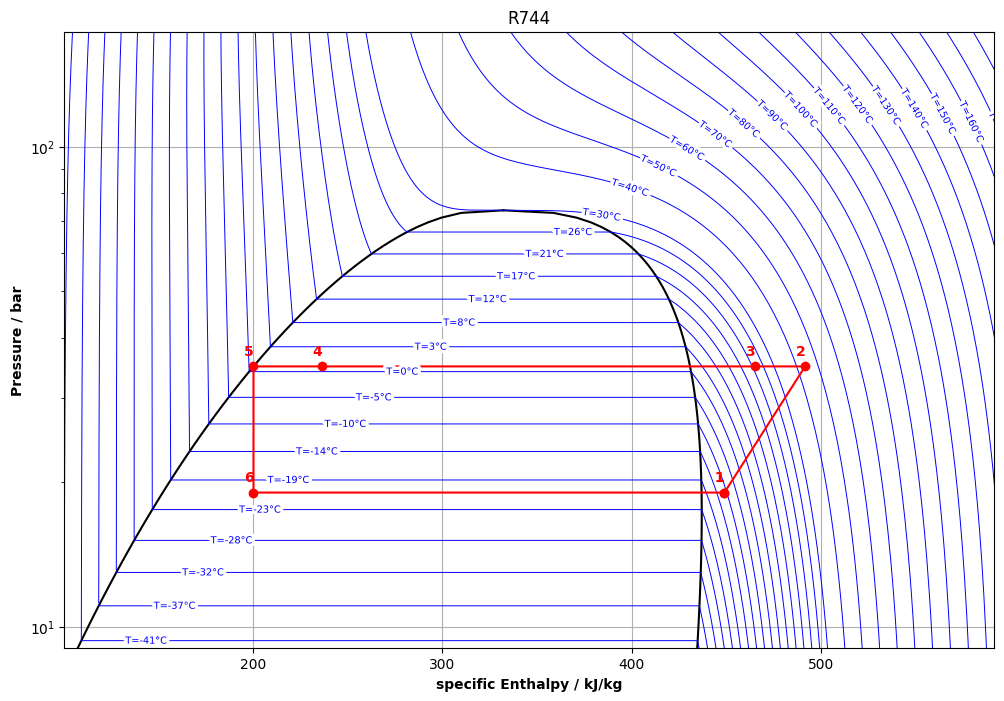

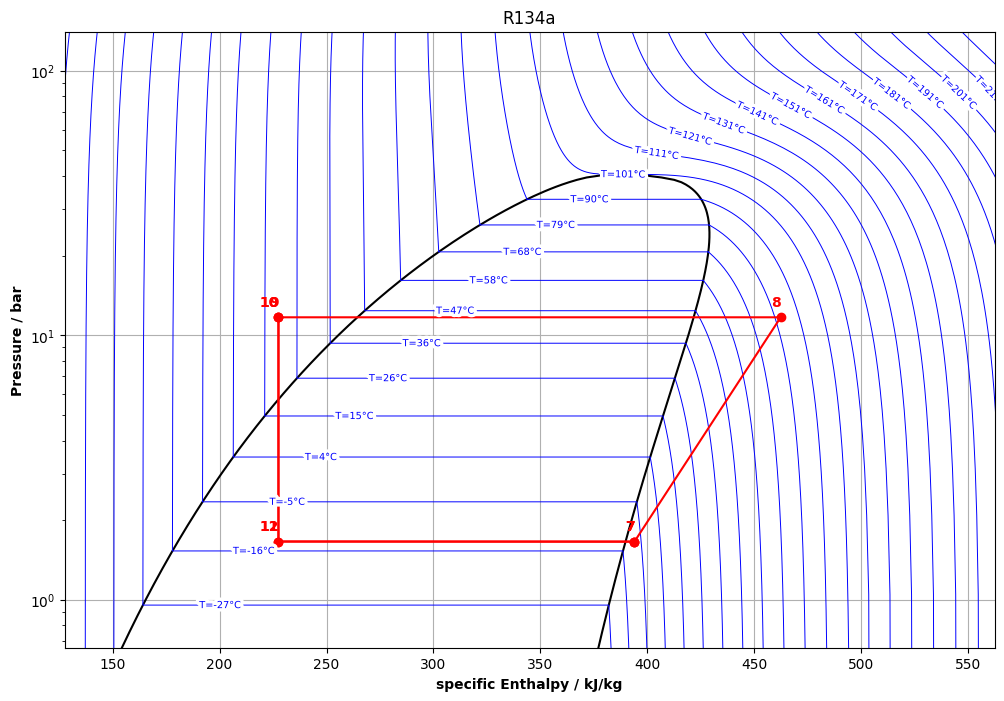

Junction 1:  p = 19.05 bar, h = 449.055 kJ/k, T = -11.077 °C, m = 0.038 kg/s
Junction 2:  p = 34.891 bar, h = 491.728 kJ/K, T = 44.874 °C, m = 0.038 kg/s
Junction 3:  p = 34.891 bar, h = 465.313 kJ/K, T = 44.874 °C, m = 0.038 kg/s
Junction 4:  p = 34.89 bar, h = 236.556 kJ/K, T = 0.042 °C, m = 0.038 kg/s
Junction 5:  p = 34.89 bar, h = 200.103 kJ/K, T = 0.042 °C, m = 0.038 kg/s
Junction 6:  p = 19.05 bar, h = 200.103 kJ/K, T = -21.077 °C, m = 0.038 kg/s
Junction 7:  p = 1.658 bar, h = 393.971 kJ/k, T = -9.721 °C, m = 0.053 kg/s
Junction 8:  p = 11.696 bar, h = 462.343 kJ/K, T = 82.217 °C, m = 0.053 kg/s
Junction 9:  p = 11.695 bar, h = 227.52 kJ/K, T = 20.0 °C, m = 0.053 kg/s
Junction 10:  p = 34.89 bar, h = 200.103 kJ/K, T = 0.042 °C, m = 0.038 kg/s
Junction 11:  p = 1.66 bar, h = 227.52 kJ/K, T = -14.699 °C, m = 0.026 kg/s
Junction 12:  p = 1.66 bar, h = 227.52 kJ/K, T = -14.699 °C, m = 0.026 kg/s


In [7]:
# resets all compontent ports
[(component.reset(), setattr(component, 'linearized', False)) for component in components]

# gets input values from widget input
inputs_cascade = wid_inputs_cascade.kwargs
pi_v_so = inputs_cascade['pi_v_so']
Ti_v_so = inputs_cascade['Ti_v_so']
mi_v_so = inputs_cascade['mi_v_so']
pi_c_so = inputs_cascade['pi_c_so']
Ti_c_so = inputs_cascade['Ti_c_so']
mi_c_so = inputs_cascade['mi_c_so']
pi_gc_so = inputs_cascade['pi_gc_so']
Ti_gc_so = inputs_cascade['Ti_gc_so']
mi_gc_so = inputs_cascade['mi_gc_so']

# gets design criteria value from widget input
dc_values_cascade = wid_DC_cascade.kwargs
SH_v = dc_values_cascade['SH_v']
SH_chx1 = dc_values_cascade['SH_chx1']
SH_chx2 = dc_values_cascade['SH_chx1']

design_equa = [SuperheatEquation(components[2], SH_chx1, 'out', 'h', psd['-c']),
               SuperheatEquation(components[3], SH_chx2, 'out', 'h', psd['-c']),
               SuperheatEquation(components[6], SH_v, 'out', 'h', psd['-c'])]

# sets input values to corresponding components
for i, c in enumerate(components):
    if c.name == 'Evaporator':
        for port in c.ports:
            if port.port_id[-1] == 1:
                port.p.set_value(pi_v_so * 1e5)
                port.h.set_value(PropsSI('H', 'P', pi_v_so * 1e5, 'T', Ti_v_so + 273.15, port.fluid))
                port.m.set_value(mi_v_so)
    if c.name == 'Gas cooler':
        for port in c.ports:
            if port.port_id[-1] == 1:
                port.p.set_value(pi_gc_so * 1e5)
                port.h.set_value(PropsSI('H', 'P', pi_gc_so * 1e5, 'T', Ti_gc_so + 273.15, port.fluid))
                port.m.set_value(mi_gc_so)
    elif c.name == 'Condenser':
        for port in c.ports:
            if port.port_id[-1] == 1:
                port.p.set_value(pi_c_so * 1e5)
                port.h.set_value(PropsSI('H', 'P', pi_c_so * 1e5, 'T', Ti_c_so + 273.15, port.fluid))
                port.m.set_value(mi_c_so)

# solver scale factors
scale_factors = [1e-5, 1e-5, 10]

# solver initial values
pi_coLT_0 = PropsSI('P', 'T', Ti_v_so - 5 + 273.15, 'Q', 1.0, fluid_list[Vt[0].port_id[-2] - 1])
hi_coLT_0 = PropsSI('H', 'P', pi_coLT_0, 'Q', 1.0, fluid_list[Vt[1].port_id[-2] - 1])
po_coLT_0 = PropsSI('P', 'T', (Ti_v_so + Ti_c_so) / 2 + 5 + 273.15, 'Q', 1.0, fluid_list[Vt[2].port_id[-2] - 1])

pi_coHT_0 = PropsSI('P', 'T', (Ti_v_so + Ti_c_so) / 2 - 5 + 273.15, 'Q', 1.0, fluid_list[Vt[3].port_id[-2] - 1])
hi_coHT_0 = PropsSI('H', 'P', pi_coHT_0, 'Q', 1.0, fluid_list[Vt[4].port_id[-2] - 1])
po_coHT_0 = PropsSI('P', 'T', Ti_c_so + 5 + 273.15, 'Q', 1.0, fluid_list[Vt[5].port_id[-2] - 1])

po_ev2_0 = PropsSI('P', 'T',  (Ti_v_so + Ti_c_so) / 2 - 5 + 273.15, 'Q', 0.0, fluid_list[Vt[6].port_id[-2] - 1])

po_ev3_0 = PropsSI('P', 'T',  (Ti_v_so + Ti_c_so) / 2 - 5 + 273.15, 'Q', 0.0, fluid_list[Vt[7].port_id[-2] - 1])

po_ev1_0 = PropsSI('P', 'T', Ti_v_so - 5 + 273.15, 'Q', 1.0, fluid_list[Vt[9].port_id[-2] - 1])

for port in components[0].ports:
    if port.port_id[2] == 1:
        port.p.set_value(pi_coLT_0)
        port.h.set_value(hi_coLT_0)
    elif port.port_id[2] == -1:
        port.p.set_value(po_coLT_0)
components[0].solve()
for port in components[0].ports:
    if port.port_id[1] == 1:
        mi_chx2_0 = port.m.value / 2
components[0].reset()

x0 = [pi_coLT_0, hi_coLT_0, po_coLT_0,
      pi_coHT_0, hi_coHT_0, po_coHT_0,
      po_ev2_0,  po_ev3_0, mi_chx2_0,
      po_ev1_0]

for i, variable in enumerate(Vt):
    if variable.var_type == 'p':
        variable.set_value(x0[i])
    elif variable.var_type == 'h':
        variable.set_value(x0[i])
    elif variable.var_type == 'm':
        variable.set_value(x0[i])

# runs the system solver to solve system
sol = system_solver(x0, Vt, components, exec_list, res_equa, design_equa, scale_factors)

# solution vector of tearing variables
x = sol['x']

if not sol['converged']:
    print(sol['message'])
    
    # resets all compontent ports
    for c in components:
            c.reset()
else:
    # solves and exectutes all system equations and components to set all component ports by its junction value corresponding
    # to the solution
    for j, variable in enumerate(Vt):
        if variable.var_type == 'p':
            variable.set_value(x[j] / scale_factors[0])
        elif variable.var_type == 'h':
            variable.set_value(x[j] / scale_factors[1])
        elif variable.var_type == 'm':
            variable.set_value(x[j] / scale_factors[2])
    for item in exec_list:
        if isinstance(item, BalanceEquation) or isinstance(item, EnthalpyFlowBalance):
            item.solve()
        elif isinstance(item, Component):
            item.solve()
            
    # junction values corresponding to the solution

    # CO2 cycle
    pi_coLT, hi_coLT, mi_coLT  = components[0].ports[0].p.value, components[0].ports[0].h.value, components[0].ports[0].m.value
    pi_gc,  hi_gc, mi_gc   = components[1].ports[0].p.value, components[1].ports[0].h.value, components[1].ports[0].m.value
    po_gc,  ho_gc, mo_gc  = components[1].ports[1].p.value, components[1].ports[1].h.value, components[1].ports[1].m.value
    pi_sepLT,  hi_sepLT, mi_sepLT   = components[4].ports[0].p.value, components[4].ports[0].h.value, components[4].ports[0].m.value
    po_sepLT,  ho_sepLT, mo_sepLT   = components[4].ports[1].p.value, components[4].ports[1].h.value, components[4].ports[1].m.value
    po_ev1,  ho_ev1, mo_ev1   = components[5].ports[1].p.value, components[5].ports[1].h.value, components[5].ports[1].m.value
    Ti_coLT = PropsSI('T', 'P', pi_coLT, 'H', hi_coLT, fluid_list[0]) - 273.15
    Ti_gc  = PropsSI('T', 'P', pi_gc, 'H', hi_gc, fluid_list[0]) - 273.15
    To_gc  = PropsSI('T', 'P', pi_gc, 'H', hi_gc, fluid_list[0]) - 273.15
    Ti_sepLT = PropsSI('T', 'P', pi_sepLT, 'H', hi_sepLT, fluid_list[0]) - 273.15
    To_sepLT  = PropsSI('T', 'P', po_sepLT, 'H', ho_sepLT, fluid_list[0]) - 273.15
    To_ev1  = PropsSI('T', 'P', po_ev1, 'H', ho_ev1, fluid_list[0]) - 273.15

    # R134a cycle
    pi_coHT, hi_coHT, mi_coHT = components[7].ports[0].p.value, components[7].ports[0].h.value, components[7].ports[0].m.value
    pi_c,  hi_c, mi_c = components[8].ports[0].p.value, components[8].ports[0].h.value, components[8].ports[0].m.value
    pi_sepHT,  hi_sepHT, mi_sepHT = components[9].ports[0].p.value, components[9].ports[0].h.value, components[9].ports[0].m.value
    po_sepHT,  ho_sepHT, mo_sepHT  = components[9].ports[1].p.value, components[9].ports[1].h.value, components[9].ports[1].m.value
    po_ev2,  ho_ev2, mo_ev2 = components[10].ports[1].p.value, components[10].ports[1].h.value, components[10].ports[1].m.value
    po_ev3,  ho_ev3, mo_ev3 = components[10].ports[1].p.value, components[10].ports[1].h.value, components[10].ports[1].m.value
    Ti_coHT = PropsSI('T', 'P', pi_coHT, 'H', hi_coHT, fluid_list[1]) - 273.15
    Ti_c  = PropsSI('T', 'P', pi_c, 'H', hi_c, fluid_list[1]) - 273.15
    Ti_sepHT = PropsSI('T', 'P', pi_sepHT, 'H', hi_sepHT, fluid_list[1]) - 273.15
    To_sepHT  = PropsSI('T', 'P', po_sepHT, 'H', ho_sepHT, fluid_list[1]) - 273.15
    To_ev2  = PropsSI('T', 'P', po_ev2, 'H', ho_ev2, fluid_list[1]) - 273.15
    To_ev3  = PropsSI('T', 'P', po_ev3, 'H', ho_ev3, fluid_list[1]) - 273.15


    # plots log ph diagramm
    
    logph([[hi_coLT * 1e-3, hi_gc * 1e-3, ho_gc * 1e-3, hi_sepLT * 1e-3, ho_sepLT * 1e-3, ho_ev1 * 1e-3, hi_coLT * 1e-3],
       [[hi_coHT * 1e-3, hi_c * 1e-3, hi_sepHT * 1e-3, ho_sepHT * 1e-3, ho_ev2 * 1e-3, hi_coHT * 1e-3], [ho_sepHT * 1e-3, ho_ev3 * 1e-3, hi_coHT * 1e-3]]],
       [[pi_coLT * 1e-5, pi_gc * 1e-5, po_gc * 1e-5, pi_sepLT * 1e-5, po_sepLT * 1e-5, po_ev1 * 1e-5, pi_coLT * 1e-5],
       [[pi_coHT * 1e-5, pi_c * 1e-5, pi_sepHT * 1e-5, po_sepHT * 1e-5, po_ev2 * 1e-5, pi_coHT * 1e-5], [po_sepHT * 1e-5, po_ev3 * 1e-5, pi_coHT * 1e-5]]],
       [[1, 2, 3, 4, 5, 6, 1], [[7, 8, 9, 10, 11, 7], [10, 12, 7]]],
       [fluid_list[0], fluid_list[1]])

    print(f'Junction 1:  p = {round(pi_coLT/1e5, 3)} bar, h = {round(hi_coLT/1e3, 3)} kJ/k, T = {round(Ti_coLT, 3)} °C, m = {round(mi_coLT, 3)} kg/s')
    print(f'Junction 2:  p = {round(pi_gc/1e5, 3)} bar, h = {round(hi_gc/1e3, 3)} kJ/K, T = {round(Ti_gc, 3)} °C, m = {round(mi_gc, 3)} kg/s')
    print(f'Junction 3:  p = {round(po_gc/1e5, 3)} bar, h = {round(ho_gc/1e3, 3)} kJ/K, T = {round(To_gc, 3)} °C, m = {round(mo_gc, 3)} kg/s')
    print(f'Junction 4:  p = {round(pi_sepLT/1e5, 3)} bar, h = {round(hi_sepLT/1e3, 3)} kJ/K, T = {round(Ti_sepLT, 3)} °C, m = {round(mi_sepLT, 3)} kg/s')
    print(f'Junction 5:  p = {round(po_sepLT/1e5, 3)} bar, h = {round(ho_sepLT/1e3, 3)} kJ/K, T = {round(To_sepLT, 3)} °C, m = {round(mo_sepLT, 3)} kg/s')
    print(f'Junction 6:  p = {round(po_ev1/1e5, 3)} bar, h = {round(ho_ev1/1e3, 3)} kJ/K, T = {round(To_ev1, 3)} °C, m = {round(mo_ev1, 3)} kg/s')

    print(f'Junction 7:  p = {round(pi_coHT/1e5, 3)} bar, h = {round(hi_coHT/1e3, 3)} kJ/k, T = {round(Ti_coHT, 3)} °C, m = {round(mi_coHT, 3)} kg/s')
    print(f'Junction 8:  p = {round(pi_c/1e5, 3)} bar, h = {round(hi_c/1e3, 3)} kJ/K, T = {round(Ti_c, 3)} °C, m = {round(mi_c, 3)} kg/s')
    print(f'Junction 9:  p = {round(pi_sepHT/1e5, 3)} bar, h = {round(hi_sepHT/1e3, 3)} kJ/K, T = {round(Ti_sepHT, 3)} °C, m = {round(mi_sepHT, 3)} kg/s')
    print(f'Junction 10:  p = {round(po_sepLT/1e5, 3)} bar, h = {round(ho_sepLT/1e3, 3)} kJ/K, T = {round(To_sepLT, 3)} °C, m = {round(mo_sepLT, 3)} kg/s')
    print(f'Junction 11:  p = {round(po_ev2/1e5, 3)} bar, h = {round(ho_ev2/1e3, 3)} kJ/K, T = {round(To_ev2, 3)} °C, m = {round(mo_ev2, 3)} kg/s')
    print(f'Junction 12:  p = {round(po_ev3/1e5, 3)} bar, h = {round(ho_ev3/1e3, 3)} kJ/K, T = {round(To_ev3, 3)} °C, m = {round(mo_ev3, 3)} kg/s')

## References

Ganz, M. (2023) *Numerical modeling and analysis of an adaptive refrigeration cycle simulator*, Master thesis, Institute of Energy Systems and Fluid Engineering IEFE, Zurich University of Applied Science, Zurich

Bitzer Software (2013) Available at: https://www.bitzer.de/ch/de/tools-archiv/software/software/versionen-software.jsp (Accessed:January 25, 2023).

Bell, H.I., Quoilin,S., Georges, E., Braun, J.E, Eckhard A. Groll, E.A., Horton, T. & Lemort,, V. (2015) A generalized moving-boundary algorithm to predict the heat transfer rate of counterflow heat exchangers for any phase configuration. *Applied Thermal Engineering*, 79:192–201, DOI: https://doi.org/10.1016/j.applthermaleng.2014.12.028

Longo, G.A (2008). Refrigerant R134a condensation heat transfer and pressure drop inside a small brazed plate heat exchanger. *International Journal of Refrigeration*, 31(5):780–789, https://doi.org/10.1016/j.ijrefrig.2007.11.017

Eldeeb, R., Aute, V., & Radermacher, R. (2016) A survey of correlations for heat transfer and pressure drop for evaporation and condensation in plate heat exchangers. *International Journal of Refrigeration*, 65:12–26, https://doi.org/10.1016/j.ijrefrig.2015.11.013

Chu, Z., & Zhang, W. (2019) Moving-boundary and finite volume coupling algorithm for heat exchanger with fluid phase change. *International Journal of Heat and Mass Transfer*, 131:313–328, https://doi.org/10.1016/j.ijheatmasstransfer.2018.11.066